# TP 7: Éléments finis en 2D

Dans ce TP, on s'intéresse à la résolution approchée du problème aux limites suivant, avec conditions aux limites de Neumann homogène :

$$
(PN)\left\{\begin{aligned}
&-\Delta u+u=f,\; \textrm{dans }\Omega,\\
&\frac{\partial u}{\partial n}=0,\; \textrm{sur }\partial\Omega
\end{aligned}
\right.
$$
où $f:\overline{\Omega}\longrightarrow\mathbb{R}$ est une fonction de classe $\mathcal{C}^2$ donnée et $\Omega$ est un ouvert régulier de $\mathbb{R}^2$ donné. 

**Q1)** Écrire la formulation variationnelle du problème $(P)$ sous la forme 
\begin{equation*}
(PNv)\ \ \ 
\begin{cases}
u\in V  \,\textrm{tel que}\\
a(v,u)=L(v),\ \,\forall\ v\in V ,
\end{cases}
\end{equation*}
où $V=H^1(\Omega)$, $a$ est une forme bilinéaire dans $V$  et $L$ une forme linéaire de $V,$ que l'on explicitera. Montrer que le problème $(PNv)$ admet une unique solution.

Soit $\mathcal T_h$ une triangulation du domaine $\Omega$ et $V_h$ l'approximation de $H^1(\Omega)$ par des éléments finis $\mathbb P_1$ associés à la triangulation $\mathcal T_h.$ On note $\{T_N\}_{N=1,\dots,Ntri}\ $ les triangles de $\mathcal T_h,$ $\{S_I\}_{I=1,\dots,NSom}\ $ les sommets de la triangulation et $\{\Phi_I\}_{I=1,\dots,NSom}\ $ les fonctions de la base de $V_h$ définies par $\Phi_I(S_J)=\delta_{IJ},\ I,J=1,\dots,NSom.$ 

Le problème discret consiste alors à chercher $u_h\in V_h$ tel que 
$$
(PNv_h)\ \ \ \ \ \ \ \ \ a(\Phi_I,u_h)=L(\Phi_I),\ \,\forall\ I=1,\dots,NSom. 
$$

**Q2)** Soit $u_h=\displaystyle{\sum_{I=1}^{{NSom}}u_I\Phi_I}.$ Montrer que $u_h$ est solution de $(PNv_h)$ si et seulement si le vecteur $U=(u_1,\dots,u_{NSom})^T$ est solution d'un système linéaire 
$$
KU+MU=F,
$$
où $K$ et $M$ sont les matrices de $\mathcal{M}^{NSom\times NSom}(\mathbb{R})$ définies par $K_{I,J}=\int_{\Omega}\nabla\Phi_I\cdot\nabla\Phi_J,$ $M_{I,J}=\int_{\Omega}\Phi_I\Phi_J,$ et où $F$ est le vecteur de $\mathbb{R}^{NSom}$ défini par $F_I=\int_{\Omega}f\Phi_I.$ 

**Maillage de $\Omega$**

Dans un premier temps on considère $\Omega$ le carré $[0,2]\times[0,2].$ 

La triangulation $\mathcal T_h$ de $\Omega$ est représentée par deux matrices. La première, que l'on appellera $T$, contient la liste des triangles. Il s'agit d'une matrice de taille $NTri\times3$ que, dans chaque ligne $N$, contient l'indice $I$ de chaque sommet $S_I$ appartenant au triangle $T_N.$ La deuxième, que l'on appellera $TabSom,$ contient les coordonnées de chaque sommet de la triangulation. C'est une matrice de taille $NSom\times2$ que, dans chaque ligne $I$ contient les coordonnées du sommet $S_I.$ 
Le code suivant crée le maillage et ces matrices.



(722, 3)


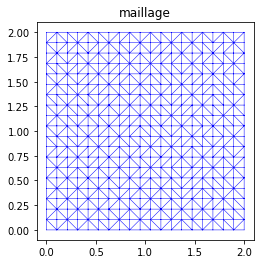

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri
import math
import numpy.random as rd
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg

Nx=18
Ny=18

x_m=0.
x_M=2.
y_m=0.
y_M=2.

x=np.linspace(x_m,x_M,Nx+2)
y=np.linspace(y_m,y_M,Ny+2)

X,Y=np.meshgrid(x,y)

X=X.flatten()
Y=Y.flatten()

X=np.vstack((X,Y)).T

triang = tri.Triangulation(X[:,0],X[:,1])

# Tableau avec noeuds des triangles
T = triang.triangles


NTri=np.shape(T)[0]
NSom=np.shape(triang.x)[0]

#Tableau avec coordonnes des noeuds
TabSom=np.zeros([NSom,2])
TabSom[:,0]=triang.x
TabSom[:,1]=triang.y


plt.figure(1)
plt.gca().set_aspect('equal')
plt.triplot(X[:,0],X[:,1],T, 'b-', lw=0.5)
plt.title('maillage')

plt.show()




**Les matrices élémentaires : la matrice de masse**

Pour construire la matrice de masse M et de rigidité K, on commence par définir des matrices élémentaires qui permettent, localement sur un triangle $T_N$ de noeuds $S_{I_1},\ S_{I_2}$ et $S_{I_3},$ de calculer 
$$
 \int_{T_N}\Phi_{I_i}\Phi_{I_j} 
$$
pour $i,\ j=1,2,3.$ Ces intégrales vont contribuer respectivement à l'élément  $M_{I_i,I_j}$ dela matrice globale.

**Q3)** Construire une fonction `M_elem(S1,S2,S3)`  calculant la matrice de masse  sur un triangle $T$ de sommets $\mathcal{S1}=(x_1,y_1),\ \mathcal{S2}=(x_2,y_2)$ et $\mathcal{S3}=(x_3,y_3).$  
Pour calculer la matrice de masse élémentaire sur le triangle $T,$ on peut utiliser les formules ci-dessous, que l'on vérifiera. 
Les fonctions de base associées à chaque sommet de $T$ sont localement données par
$$
\lambda_1(x,y)=\frac{1}{D}(y_{23}(x-x_3)-x_{23}(y-y_3)),\ \ \ \lambda_2(x,y)=\frac{1}{D}(y_{31}(x-x_1)-x_{31}(y-y_1)),\ \ \ \lambda_3(x,y)=\frac{1}{D}(y_{12}(x-x_2)-x_{12}(y-y_2)),
$$
où $x_{ij}=x_i-x_j,\ y_{ij}=y_i-y_j$ et $D=x_{23}y_{31}-x_{31}y_{23}.$ $|D|$ est égal à deux fois la surface du triangle.

Pour $k_1,\ k_2,\ k_3\in\{0,1,2\},$ on a 
$$
\int_{T}\lambda_1^{k_1}\lambda_2^{k_2}\lambda_3^{k_3}=\frac{k_1!k_2!k_3!}{(k_1+k_2+k_3+2)!}|D|.
$$

In [27]:
# <completer>


**Assemblage de la matrice $M$**

Dans cette partie on met en oeuvre un algorithme pour construire la matrice $M$. Pour ce faire on remarque que, par exemple, 
$$
M_{I,J}=\sum_{N=1}^{NTri}\int_{T_N}\Phi_I\Phi_J=\sum_{N : S_I,S_J\in T_N}\int_{T_N}\Phi_I\Phi_J.
$$

L'algoritme de construction des matrices consiste alors à faire la boucle suivante :

    Pour N= 1...NTri
         Détérmination des sommets S_I1, S_I2 et S_I3 du triangle T_N
         Calcul des matrices élémentaires associées au triangle T_N
             Pour i=1..3
                Pour j=1...3 
                    M(Ii,Ij)=M(Ii,Ij)+M_elem(i,j)

**Q4)** Compléter dans le programme l'assemblage de la matrice M

In [31]:
M = np.zeros([NSom,NSom])

# <completer>


**La matrice de rigidité**

Pour construire la matrice de rigidité on utilisera la code ci-dessous. 

**Q5)** Expliquer le fonctionnement du code


In [32]:
# calcule la normale d'une famille de triangles triangle 3D, en déduit le gradient des fonctions dont 
# les triangles sont le graphe
def tri_gradient(A,B,C):
    N = np.cross(B - A, C-B)
    Gx = -N[:,0] / N[:,2]
    Gy = -N[:,1] / N[:,2]
    return Gx, Gy


def matrice_rigidite(X,T):
    nt = T.shape[0];
    npts = X.shape[0];
  
    A = X[T[:,0],:]; # liste des points A des triangles
    B = X[T[:,1],:]; # liste des points B des triangles
    C = X[T[:,2],:]; # liste des points C des triangles
  
    # calcul de dx et dy sur chaque triangle, en fonction de la valeur de
    # la fonction aux sommets du triangle
    Z = np.zeros((nt,1));
    I = np.ones((nt,1));
    [Gx1,Gy1] = tri_gradient(np.hstack((A,I)),np.hstack((B,Z)),np.hstack((C,Z)));
    [Gx2,Gy2] = tri_gradient(np.hstack((A,Z)),np.hstack((B,I)),np.hstack((C,Z)));
    [Gx3,Gy3] = tri_gradient(np.hstack((A,Z)),np.hstack((B,Z)),np.hstack((C,I)));
  
    # assemblage des matrices creuses
    # pour chaque triangle 1\leq t \leq nt, on a trois coefficients non nuls
    # en (t,a), (t,b), (t,c) où a = T[i,1], b=T[i,2], c=T[i,3]
    I = np.hstack((np.arange(nt), np.arange(nt), np.arange(nt)))
    J = np.hstack((T[:,0], T[:,1], T[:,2]))
    Sx = np.hstack((Gx1,Gx2,Gx3))
    Sy = np.hstack((Gy1,Gy2,Gy3))
    
    # les matrices creuses sont construites de la manière suivante:
    # pour tout l dans 0, ..., len(J)-1, on pose dx[I[k],J[k]] = Sx[k]
    dx = sp.csc_matrix((Sx,(I,J)),shape=(nt,npts))
    dy = sp.csc_matrix((Sy,(I,J)),shape=(nt,npts))
    
    # calcul de l'aire des triangles:
    AB = B-A
    BC = C-B
    aires = .5*(AB[:,0]*BC[:,1] - AB[:,1]*BC[:,0])
    
    return dx.T*sp.diags(aires)*dx + dy.T*sp.diags(aires)*dy



**Calcul du second membre $F.$**

On peut calculer exactement les composantes $F_I$ du vecteur $F$ ou approcher ses valeurs en utilisant par exemple des formules de quadrature.

Ici on fait le choix de remplacer $f$ par son interpolé $\mathbb P_1$ aux points du maillage, *i.e.* on approche $f$ par la fonction $\displaystyle{\sum_{I=1}^{NSom}f(S_I)\Phi_I}.$ 

**Q6)** En approchant $f$ par son interpolé, donner une approximation du second membre $F$ faisant intervenir la matrice de masse.  

On admet que cette approximation ne change pas l'approximation par éléments finis du problème. 

**Validation : calcul d'une solution connue**

On considère $f$ tel que la fonction
$$
u(x,y)=\cos(\pi x)\cos(2\pi y)
$$
est solution du problème (PN) dans $\Omega=[0,2]\times[0,2].$ 

**Q7)** Construire dans le programme une fonction $f(x,y)$ définissant le second membre $f$ et calculer l'approximation du vecteur $F$ obtenue comme expliqué dessus. Calculer le vecteur $U$ des coefficients de la solution approchée donnée par la méthode des élements finis et utiliser le code suivant pour la visualiser.

In [35]:
# <completer>
plt.figure(2)
plt.gca().set_aspect('equal')
#plt.tripcolor(triang, U, shading='flat')
plt.tripcolor(triang.x,triang.y,triang.triangles, u, shading='flat')
plt.colorbar()
plt.title('solution approchee par EF P1')

plt.show()